<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D0%BF%D1%80%D0%B8_%D0%BF%D0%BE%D0%B3%D0%BB%D0%BE%D1%89%D0%B5%D0%BD%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подгружаем необходимые библиотеки 

In [48]:
import numpy as np
import pandas as pd

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [50]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

Подгружаем данные из SDSS обзора, которые были получены: http://skyserver.sdss.org/CasJobs/mydbcontent.aspx?ObjName=SpecPhotoAll&ObjType=TABLE&context=DR16&type=normal 

Здесь уже выполнены следующие преобразования:

1) Удалены строчки с разряженными данными (где отсутствуют интересующие нас фотометрические признаки), выбросы, удалены не интересующие нас признаки

2) Удалены дубрирующиеся данные

3) Объединены основные спектральные классы звезд 

In [51]:
df = pd.read_csv('/content/drive/MyDrive/Научная работа/Nauch/Результат/data/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [52]:
df.shape

(4614588, 17)

In [53]:
df.describe()

,objID,ra,dec,z,zErr,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
count,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06
mean,1.237665e+18,1.728012e+02,2.406577e+01,5.773699e-01,5.854844e-02,2.240051e+01,2.122111e+01,2.029666e+01,1.974275e+01,1.938488e+01,2.136179e+01,2.051423e+01,1.961589e+01,1.905677e+01,1.868825e+01
std,8.417649e+12,9.444408e+01,1.910161e+01,7.297733e-01,1.930832e+01,1.954846e+00,1.940199e+00,1.713228e+00,1.552831e+00,1.512268e+00,2.117606e+00,1.993697e+00,1.852755e+00,1.742048e+00,1.677772e+00
min,1.237646e+18,9.090791e-05,-1.970271e+01,-1.144691e-02,-6.000000e+00,6.752299e+00,7.464891e+00,8.449972e+00,7.611034e+00,6.444011e+00,1.020505e+01,1.043573e+01,1.033073e+01,1.027642e+01,8.829096e+00
25%,1.237659e+18,1.271012e+02,6.893257e+00,6.228666e-02,2.494150e-05,2.105644e+01,1.980771e+01,1.908989e+01,1.871800e+01,1.840915e+01,1.987525e+01,1.888042e+01,1.805814e+01,1.767278e+01,1.742591e+01
50%,1.237664e+18,1.741648e+02,2.352539e+01,4.268281e-01,9.249016e-05,2.259238e+01,2.147956e+01,2.063976e+01,2.007801e+01,1.967025e+01,2.116473e+01,2.097991e+01,2.011406e+01,1.942030e+01,1.898551e+01
75%,1.237668e+18,2.271129e+02,3.864779e+01,7.037950e-01,1.989703e-04,2.390630e+01,2.277750e+01,2.155568e+01,2.080758e+01,2.034762e+01,2.250614e+01,2.198993e+01,2.102539e+01,2.035791e+01,1.984414e+01
max,1.237681e+18,3.599999e+02,8.485214e+01,7.051930e+00,3.068822e+04,3.192045e+01,3.032868e+01,2.971638e+01,2.995165e+01,2.748061e+01,3.428534e+01,3.330923e+01,3.088891e+01,3.268382e+01,3.119199e+01


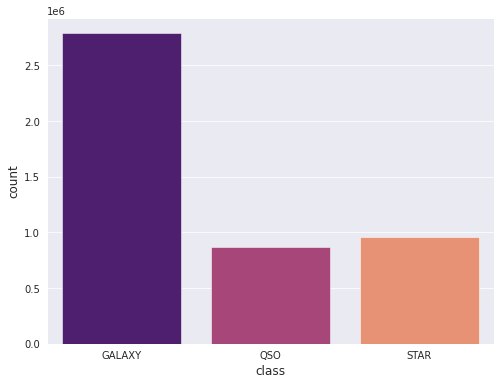

In [54]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=df['class'], palette = 'magma')

# Подготовка данных для классификатора

Классификатор звезд против галактик и квазаров 

In [55]:
df_main = df.copy()
labels = {'STAR':0, 'GALAXY':1, 'QSO':1}
df_main.replace({'class':labels}, inplace = True)
df_main.head()

labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({'class':labels}, inplace = True)
c = df['class'].values


In [56]:
X_main =  df_main.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1).values
y_main = df_main['class'].values
X_main.shape

(4614588, 10)

In [57]:
def data_preparation(X, y, c, test_size = 0.8):

    count = np.min(((y==1).sum(), (y==0).sum()))
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[c==2], y[c==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[c==3], y[c==3], test_size=test_size, random_state = 43)
    
    count = X0_train.shape[0]
    count1 = X0_test.shape[0]
    #i1 = 5
    i2 = 4
    i3 = 2
    X_train, X_test = np.concatenate((X0_train[:count], X2_train[:count//i2], X3_train[:2*count//i3])), np.concatenate((X0_test, X2_test[:count1//2], X3_test[:count1//2]))
    y_train, y_test = np.concatenate((y0_train[:count], y2_train[:count//i2], y3_train[:2*count//i3])), np.concatenate((y0_test, y2_test[:count1//2], y3_test[:count1//2]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train[:count//i2].copy()
    X3_train_not_scaling = X3_train[:2*count//i3].copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_train[count//i2:])).copy()
    X3_test_not_scaling = np.concatenate((X3_test, X3_train[count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    #X1_test = robust.transform(X1_test)
    #X1_train = robust.transform(X1_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_train[count//i2:])))
    y2_test = np.concatenate((y2_test, y2_train[count//i2:]))
    X2_train = robust.transform(X2_train[:count//i2])
    y2_train = y2_train[:count//i2]
    X3_test = robust.transform(np.concatenate((X3_test, X3_train[count//i3:])))
    y3_test = np.concatenate((y3_test, y3_train[count//i3:]))
    X3_train = robust.transform(X3_train[:count//i3])
    y3_train = y3_train[:count//i3]
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

Теперь подготовка данных для OB

In [ ]:
df_g_q = df.copy()
df_g_q['ob'] = 1
df_g_q['ob'][df_g_q['subClass'] == 'OB'] = 0

In [59]:
df_g_q = df_g_q[(df_g_q['class'] != 1) | (df_g_q['ob'] == 0)] #оставляе в выборке только ОВ звезды, галактики и квазары
df_g_q.shape

(3667956, 18)

In [60]:
df_g_q.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,ob
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,2,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795,1
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,3,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354,1
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,2,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257,1
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,2,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923,1
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,2,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757,1


In [61]:
X_g_q =  df_g_q.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y_g_q = df_g_q['ob'].values
c_g_q = df_g_q['class'].values

Ниже представлена функция для разделения выборки на тестовую и обучающую с нормировкой признаков

# Классификаторы OB против Галактик и Квазаров

In [62]:
def data_preparation_gq(X, y, c, test_size = 0.2):
    count = np.min(((y==1).sum(), (y==0).sum()))
    print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, )), np.zeros((1, ))
    X2_train, X2_test, y2_train, y2_test, X2_add, y2_add = np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, )), np.zeros((1, )), np.zeros((1, 10)), np.zeros((1, ))
    X3_train, X3_test, y3_train, y3_test, X3_add, y3_add = np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, )), np.zeros((1, )), np.zeros((1, 10)), np.zeros((1, ))
  
    n = 10

    X0 = X[y==0]
    y0 = y[y==0]
    X2 = X[c==2]
    y2 = y[c==2]
    X3 = X[c==3]
    y3 = y[c==3]

    X0 = X0[X0[:,7].argsort()]
    y0 = y0[X0[:,7].argsort()]

    shift = len(y0)//n

    for i in range(0, n):
            #проходим для каждого смещения по яркости
            r1 = X0[i*shift][7]
            r2 = X0[(i+1) * shift - 1][7]
            X20, X30 = X2[(X2[:, 7] >= r1) & (X2[:, 7] <= r2)], X3[(X3[:, 7] >= r1) & (X3[:, 7] <= r2)]
            y20, y30 = y2[(X2[:, 7] >= r1) & (X2[:, 7] <= r2)], y3[(X3[:, 7] >= r1) & (X3[:, 7] <= r2)]

            #сохраняем неиспользуемые примеры
            ind2 = np.random.choice(len(y20), size=shift//2, replace=False)
            ind0 = np.arange(len(y20))
            ind = np.array([x for x in ind0 if x not in ind2])
            X2_add = np.concatenate((X2_add, X20[ind]))
            y2_add = np.concatenate((y2_add, y20[ind]))

            ind3 = np.random.choice(len(y30), size=shift//2, replace=False)
            ind0 = np.arange(len(y30))
            ind = np.array([x for x in ind0 if x not in ind3])
            X3_add = np.concatenate((X3_add, X30[ind]))
            y3_add = np.concatenate((y3_add, y30[ind]))

            #разделяем на тестовую и обучающую выборку
            X_train, X_test, y_train, y_test = train_test_split(X0[i*shift : (i+1) * shift - 1], y0[i*shift : (i+1) * shift - 1], test_size=test_size, random_state = 43)
            X0_train, X0_test = np.concatenate((X0_train, X_train)), np.concatenate((X0_test, X_test))
            y0_train, y0_test = np.concatenate((y0_train, y_train)), np.concatenate((y0_test, y_test))

            X_train, X_test, y_train, y_test = train_test_split(X20[ind2], y20[ind2], test_size=test_size, random_state = 43)
            X2_train, X2_test = np.concatenate((X2_train, X_train)), np.concatenate((X2_test, X_test))
            y2_train, y2_test = np.concatenate((y2_train, y_train)), np.concatenate((y2_test, y_test)) 

            X_train, X_test, y_train, y_test = train_test_split(X30[ind3], y30[ind3], test_size=test_size, random_state = 43)
            X3_train, X3_test = np.concatenate((X3_train, X_train)), np.concatenate((X3_test, X_test))
            y3_train, y3_test = np.concatenate((y3_train, y_train)), np.concatenate((y3_test, y_test)) 

    X_train, X_test = np.concatenate((X0_train[1:], X2_train[1:], X3_train[1:])), np.concatenate((X0_test[1:], X2_test[1:], X3_test[1:]))
    y_train, y_test = np.concatenate((y0_train[1:], y2_train[1:], y3_train[1:])), np.concatenate((y0_test[1:], y2_test[1:], y3_test[1:]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train.copy()
    X3_train_not_scaling = X3_train.copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_add))
    X3_test_not_scaling = np.concatenate((X3_test, X3_add))

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_add)))
    y2_test = np.concatenate((y2_test, y2_add))
    X2_train = robust.transform(X2_train)
    X3_test = robust.transform(np.concatenate((X3_test, X3_add)))
    y3_test = np.concatenate((y3_test, y3_add))
    X3_train = robust.transform(X3_train)
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

In [63]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation_gq(X_g_q, y_g_q, c_g_q, 0.3)

13731 13731 3654225


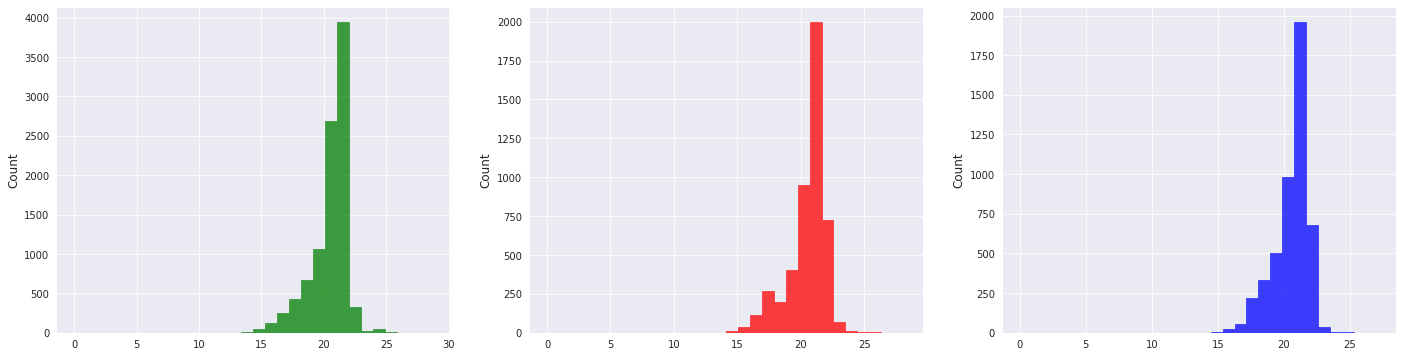

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train_not_scaling[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train_not_scaling[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

In [65]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      4120
         1.0       0.91      0.86      0.88      4120

    accuracy                           0.89      8240
   macro avg       0.89      0.89      0.89      8240
weighted avg       0.89      0.89      0.89      8240

Confusion Matrix: 
 [[3752  368]
 [ 565 3555]]
Training Score:  1.0
Testing Score:  0.8867718446601942
36.64186716079712


In [66]:
from lightgbm import LGBMClassifier

gb = LGBMClassifier(n_estimators=1100, num_leaves=60, learning_rate=0.005, max_depth=13, min_child_weight=1, subsample=0.9244, colsample_bytree=0.4)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      4120
         1.0       0.90      0.85      0.88      4120

    accuracy                           0.88      8240
   macro avg       0.88      0.88      0.88      8240
weighted avg       0.88      0.88      0.88      8240

Confusion Matrix: 
 [[3749  371]
 [ 598 3522]]
Training Score:  0.9055729166666666
Testing Score:  0.8824029126213592


# Поверка на данных с измененным поглощением (сначала для OB против Галактик и Квазаров): 

In [85]:
coeff = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263} #Rv = 3.1 (коэффициенты для изменеия поглощения звезд)

In [86]:
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,2,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,3,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,2,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,2,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,2,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [87]:
def extinction(X_, Ebv): #добавление поглощения в данную выборку при заданном EBV

    X = X_.copy()
    for Mag in [0, 5]:
        for i, filters in enumerate(['u', 'g', 'r', 'i', 'z']):
            X[:, Mag+i] = X[:, Mag+i] + float(Ebv * coeff[filters])
    return X


In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score

def Acc(Model, X_main, X_fit, y, x0=0, x1=2.125, shift=0.125):
    
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []
    robust = RobustScaler()
    robust.fit_transform(X_fit)
    
    EBV = np.arange(x0, x1, shift)
    
    for Ebv in tqdm(EBV):
        X = X_main.copy()
        X = extinction(X, Ebv)
        
        X_test = robust.transform(X)
        
        test_ans = Model.predict(X_test)
        test_acc.append(accuracy_score(y, test_ans))
        test_f1.append(f1_score(y, test_ans, zero_division=0))
        test_precision.append(precision_score(y, test_ans, zero_division=0))
        test_recall.append(recall_score(y, test_ans, zero_division=0))

    
    return test_acc, test_f1, test_precision, test_recall, EBV

In [89]:
def visualize(test_metric_acc, train_metric_acc, test_metric_f1, train_metric_f1, test_metric_precision, train_metric_precision, test_metric_recall, train_metric_recall, grid, xlabel ='X'):
        
        def pl(metric, test_metric, train_metric):

            train, test = np.asarray(train_metric), np.asarray(test_metric)

            plt.style.use('ggplot')
            plt.figure(figsize=(16, 8))
            plt.title(metric)
            plt.plot(grid, test, label="rf")
            plt.plot(grid, train, label="gb")
            plt.xlabel(xlabel)
            plt.legend()
            plt.show()


        pl("Accuracy", test_metric_acc, train_metric_acc)
        pl("F1_score", test_metric_f1, train_metric_f1)
        pl("Precision", test_metric_precision, train_metric_precision)
        pl("Recall", test_metric_recall, train_metric_recall)

In [93]:
def AU_REC(Model, X_main, X_fit, y, title="Precision recall curve", x0=0, x1=2.2, shift=0.2):

    from sklearn.metrics import precision_recall_curve, average_precision_score

    robust = RobustScaler()
    robust.fit_transform(X_fit)
    
    EBV = np.arange(x0, x1, shift)
    
    
    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    AP = []
    clr = ['red', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'lime', 'springgreen', 'aquamarine', 'aqua', 'skyblue', 'lightskyblue', ]
    j = 0
   
    for Ebv in tqdm(EBV):
            X = X_main.copy()
            X = extinction(X, Ebv)
            X_test = robust.transform(X)
            test_ans = Model.predict_proba(X_test)

            f, t, thresholds = precision_recall_curve(y, test_ans[:,1], pos_label=1)
            l, = plt.plot(t, f, color=clr[j], lw=2)
            j+=1
            lines.append(l)
            labels.append('EBV = ' + str(round(Ebv, 1)))
            AP.append(average_precision_score(y, test_ans[:,1]))
            
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    #plt.xlim([15, 23])
    plt.ylim([0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -0.75), prop=dict(size=14))
    plt.show()

    plt.figure()
    plt.title('AP')
    plt.plot(EBV, AP, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0, 1])
    plt.xlim([x0,x1-shift])
    plt.ylabel('AP')
    plt.xlabel('EBV')
    plt.show()


In [94]:
def AUC_ROC(Model, X_main, X_fit, y, title="ROC", x0=0, x1=2.2, shift=0.2):

    from sklearn.metrics import roc_curve, auc

    robust = RobustScaler()
    robust.fit_transform(X_fit)
    
    EBV = np.arange(x0, x1, shift)
    
    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    AP = []
    clr = ['red', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'lime', 'springgreen', 'aquamarine', 'aqua', 'skyblue', 'lightskyblue', ]
    j = 0
   
    for Ebv in tqdm(EBV):
            X = X_main.copy()
            X = extinction(X, Ebv)
            X_test = robust.transform(X)
            test_ans = Model.predict_proba(X_test)

            f, t, thresholds = roc_curve(y, test_ans[:,1], pos_label=1)
            l, = plt.plot(f, t, color=clr[j], lw=2)
            j+=1
            lines.append(l)
            labels.append('EBV = ' + str(round(Ebv, 1)))
            AP.append(auc(f, t))
            
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    #plt.xlim([15, 23])
    plt.ylim([0, 1.05])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -0.75), prop=dict(size=14))
    plt.show()

    plt.figure()
    plt.title('AP')
    plt.plot(EBV, AP, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0, 1])
    plt.xlim([x0, x1-shift])
    plt.ylabel('AUC')
    plt.xlabel('EBV')
    plt.show()


Поводим эксперементы на классификаторах с разделением тестовых данных по количеству 

Эксперементы для классификаторов, чья выборка была разделена равномерно по яркости 

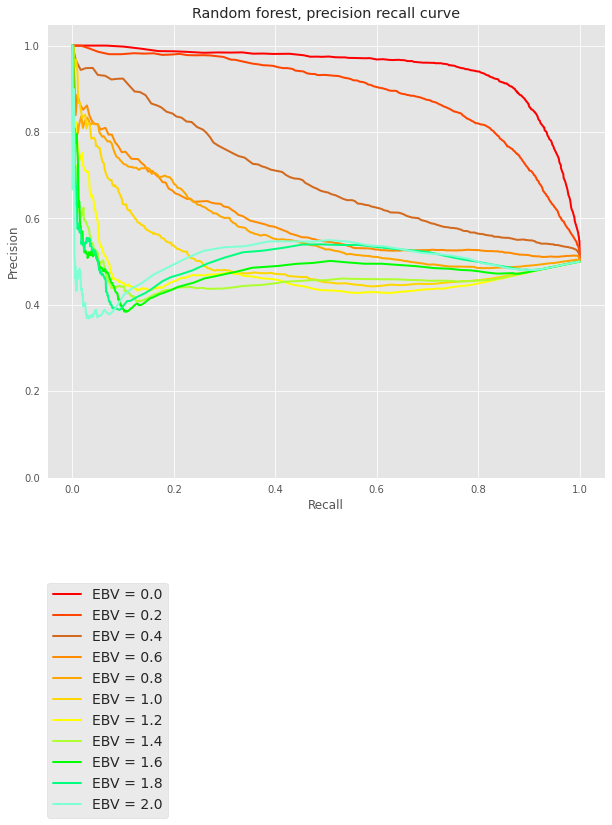

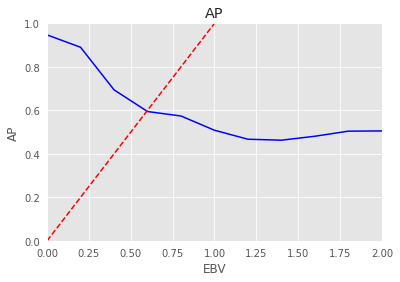

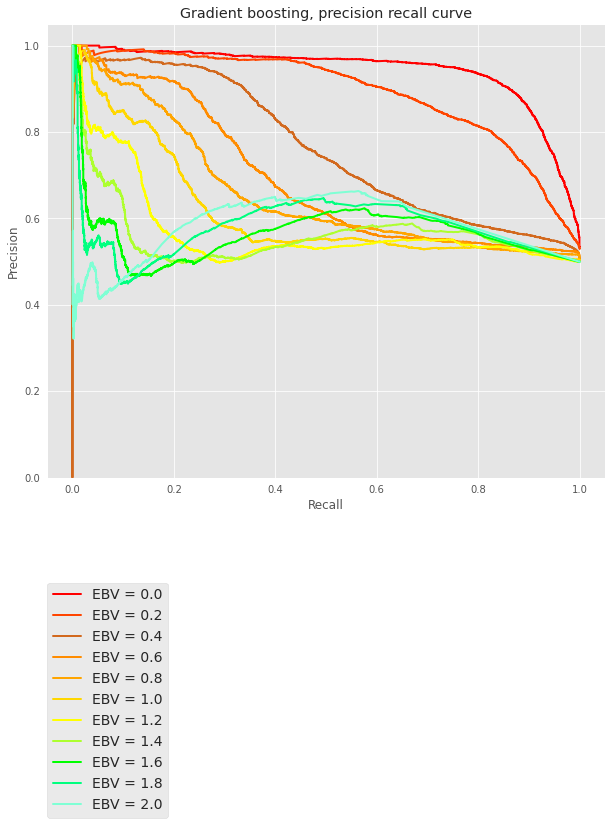

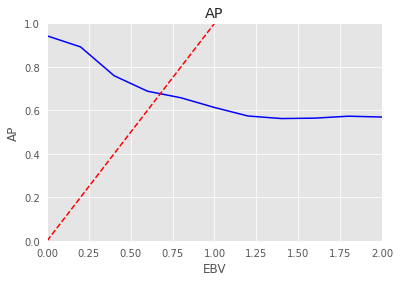

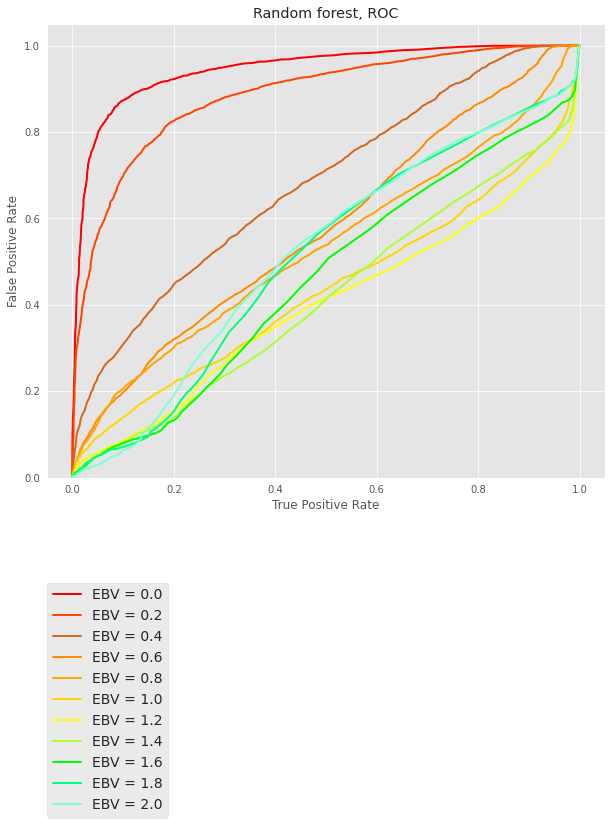

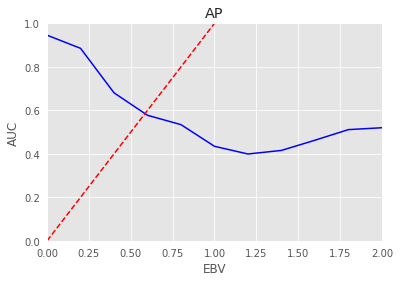

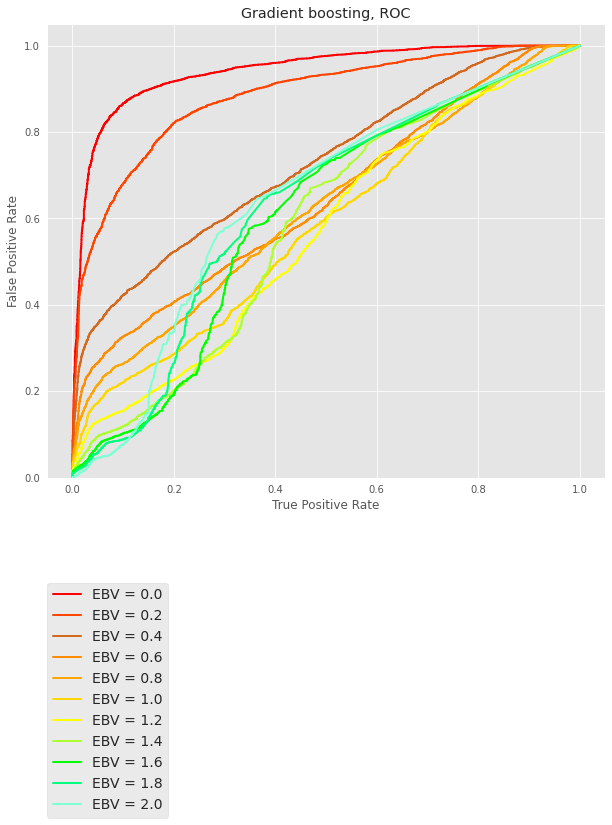

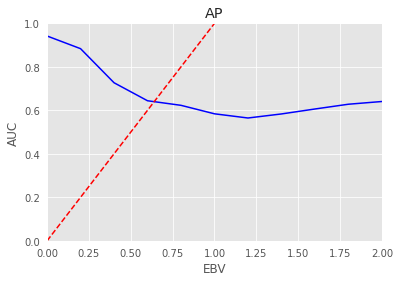

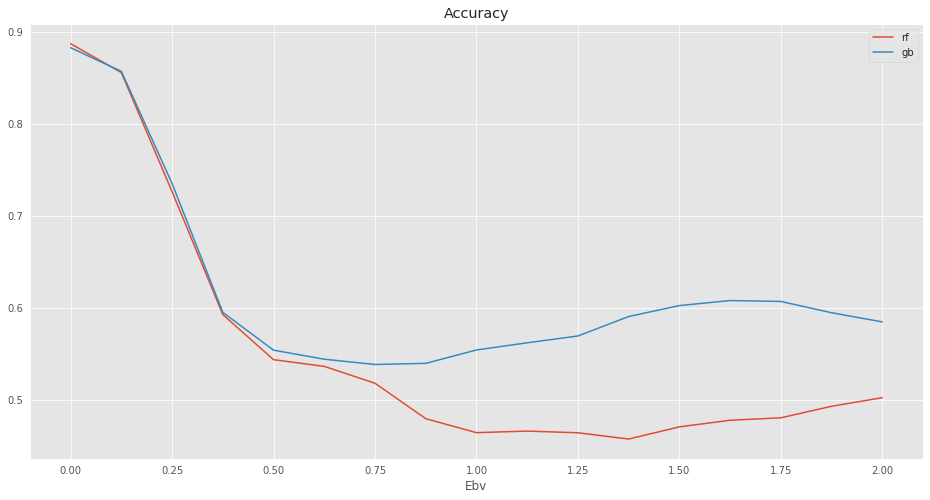

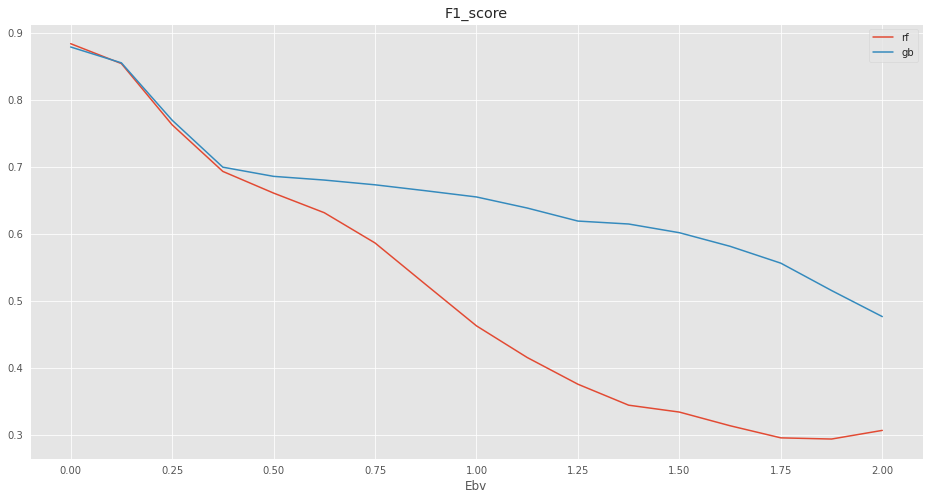

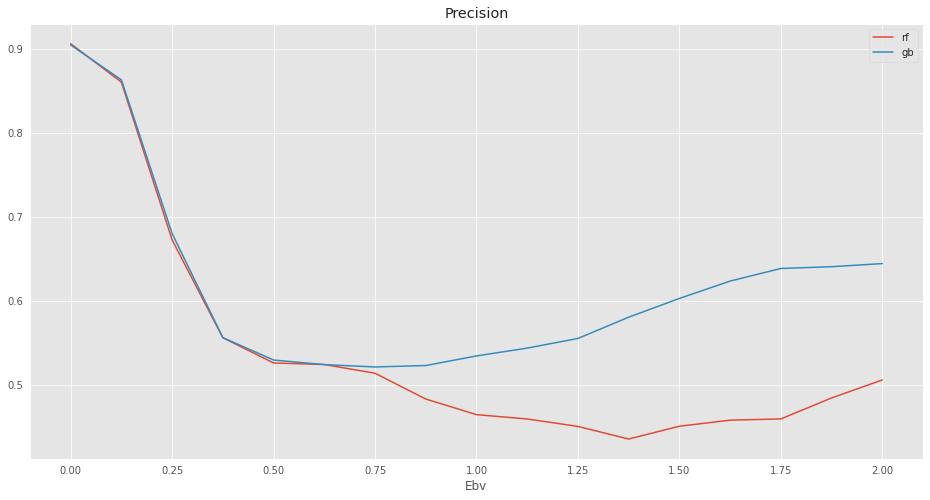

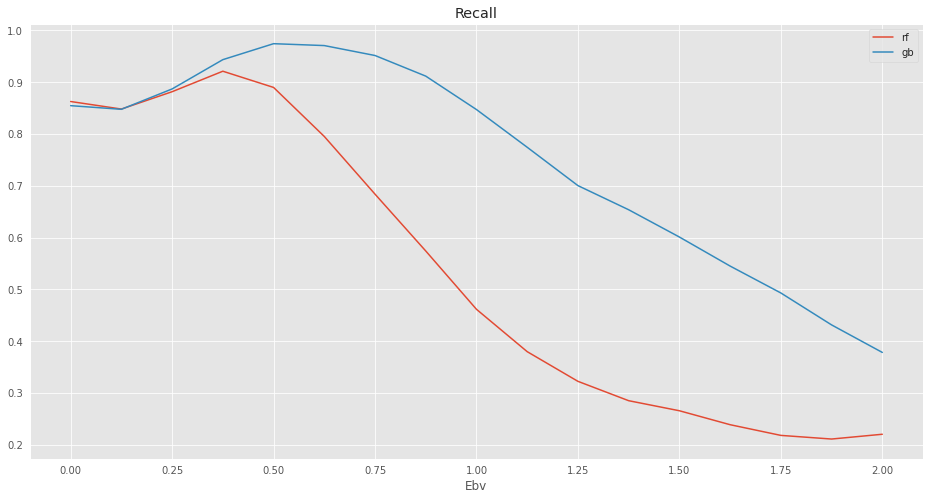

In [95]:
#Искажаем все данные (запускаются функции для прорисовки графиков)
AU_REC(rf, X_test_not_scaling, X_train_not_scaling, y_test, "Random forest, precision recall curve")
AU_REC(gb, X_test_not_scaling, X_train_not_scaling, y_test, "Gradient boosting, precision recall curve")
AUC_ROC(rf, X_test_not_scaling, X_train_not_scaling, y_test, "Random forest, ROC")
AUC_ROC(gb, X_test_not_scaling, X_train_not_scaling, y_test, "Gradient boosting, ROC")
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

# Проверим влияние ошибки на поглощение. 

In [96]:
X_train_not_scaling1 = extinction(X_train_not_scaling, 1)
r = RobustScaler()
X_train1 = r.fit_transform(X_train_not_scaling1)
X_test_not_scaling1 = extinction(X_test_not_scaling, 1)
X_test1 = r.transform(X_test_not_scaling1)

In [97]:
print(X_test_not_scaling[1, :5])
print(X_test_not_scaling1[1, :5])
print(X_test[1, :5])
print(X_test1[1, :5]) # после нормальзации выборки становятся одинаковыми 

[19.2693  18.0936  17.85487 17.79378 17.78312]
[23.5083  21.3966  20.13987 19.49178 19.04612]
[-1.37997735 -2.02228594 -2.1999595  -2.22901533 -2.00578232]
[-1.37997735 -2.02228594 -2.1999595  -2.22901533 -2.00578232]


In [98]:
rf1 = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf1.fit(X_train1, y_train)
y_pred = rf1.predict(X_test1)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf1.score(X_train1, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf1.score(X_test1, y_test)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      4120
         1.0       0.91      0.86      0.88      4120

    accuracy                           0.89      8240
   macro avg       0.89      0.89      0.89      8240
weighted avg       0.89      0.89      0.89      8240

Confusion Matrix: 
 [[3752  368]
 [ 565 3555]]
Training Score:  1.0
Testing Score:  0.8867718446601942


In [99]:
gb1 = LGBMClassifier(n_estimators=1100,
                     num_leaves=60,
                     learning_rate=0.005,
                     max_depth=13,
                     min_child_weight=1,
                     subsample=0.9244,
                     colsample_bytree=0.4)
gb1.fit(X_train1, y_train)
pred = gb1.predict(X_test1)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb1.score(X_train1, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb1.score(X_test1, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      4120
         1.0       0.90      0.85      0.88      4120

    accuracy                           0.88      8240
   macro avg       0.88      0.88      0.88      8240
weighted avg       0.88      0.88      0.88      8240

Confusion Matrix: 
 [[3749  371]
 [ 598 3522]]
Training Score:  0.9055729166666666
Testing Score:  0.8824029126213592


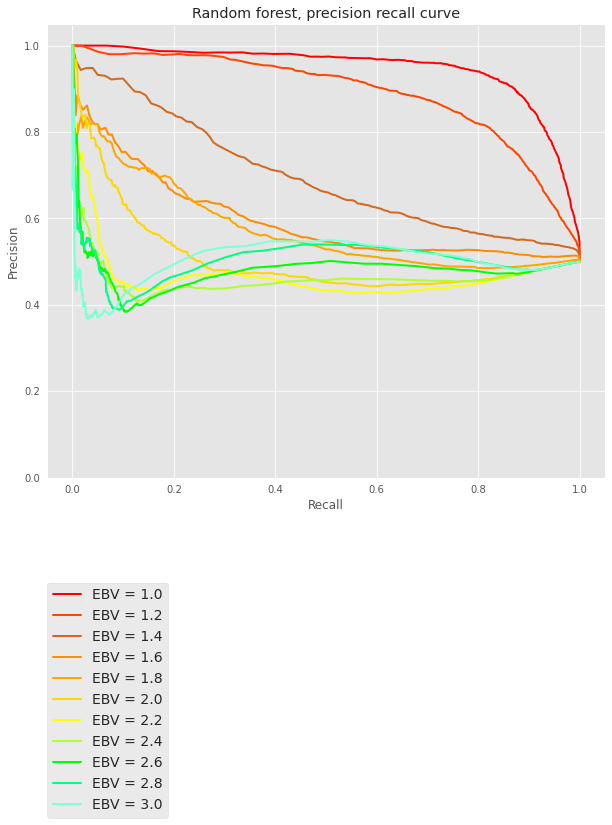

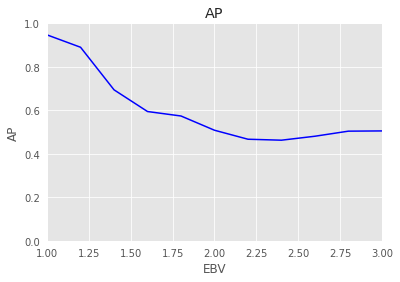

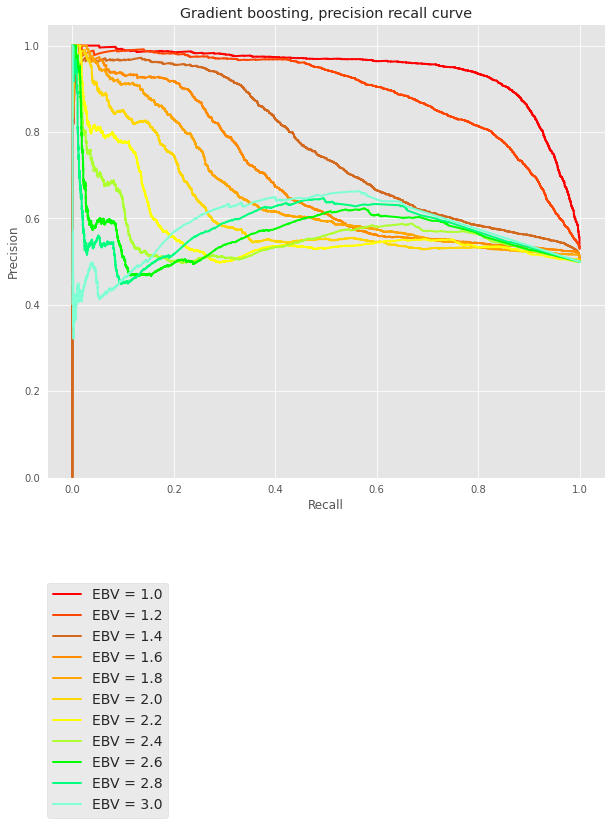

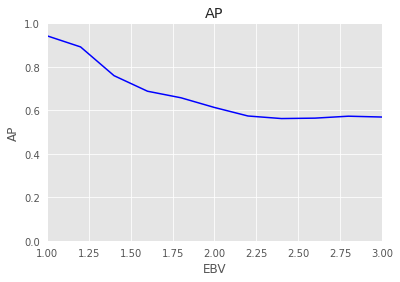

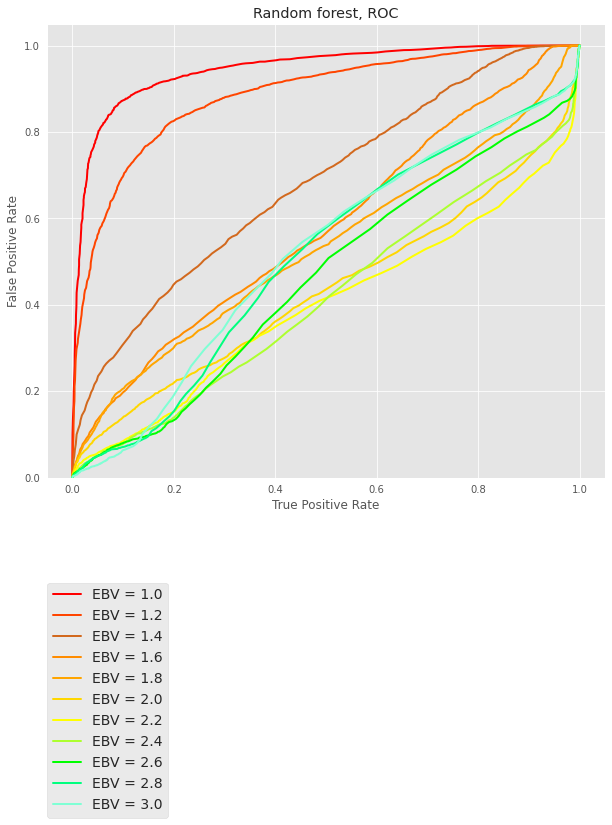

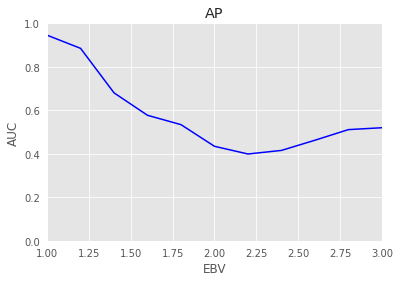

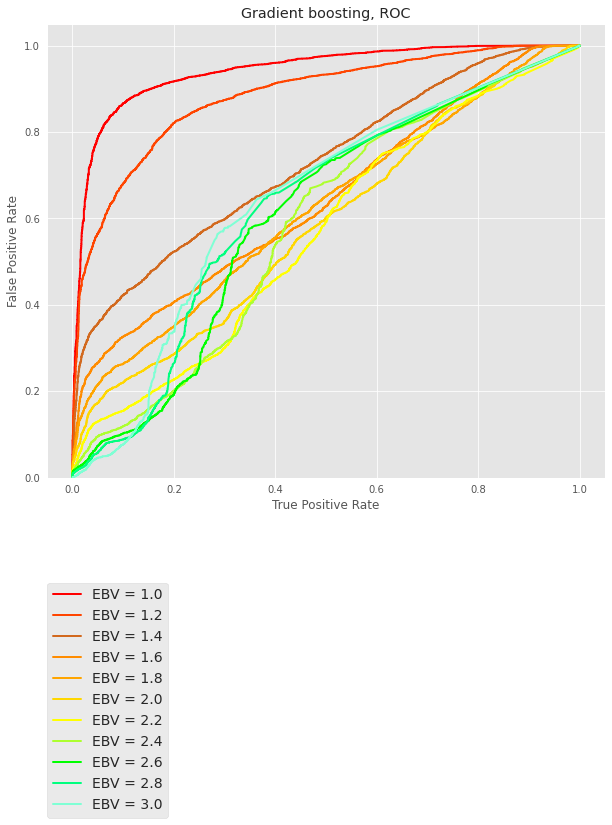

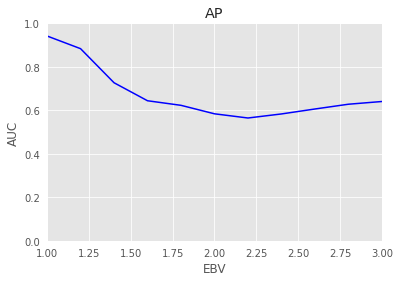

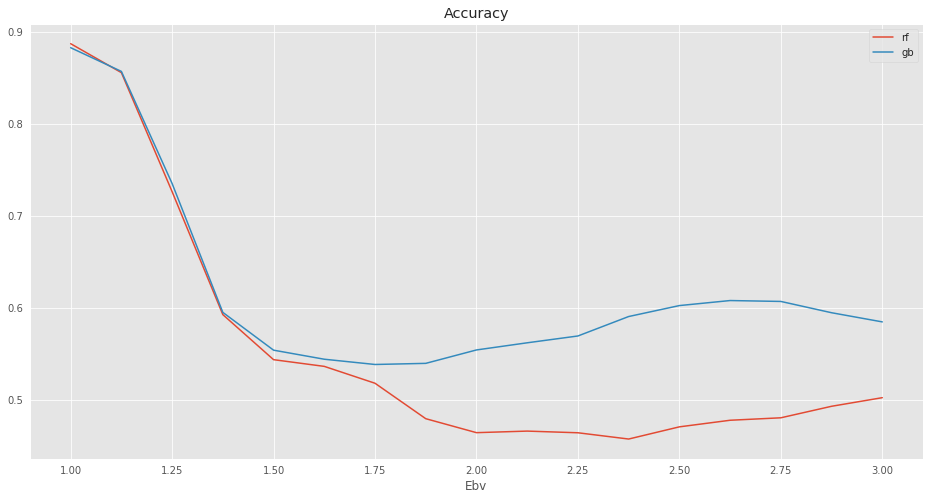

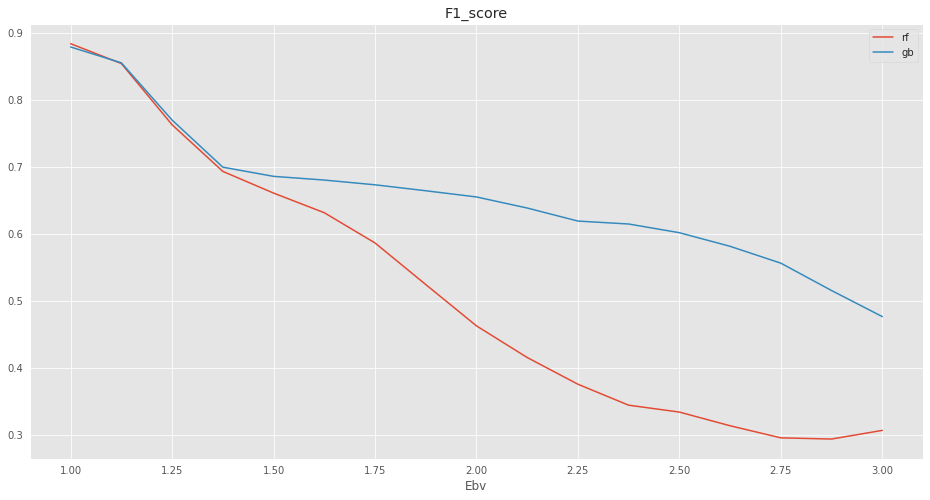

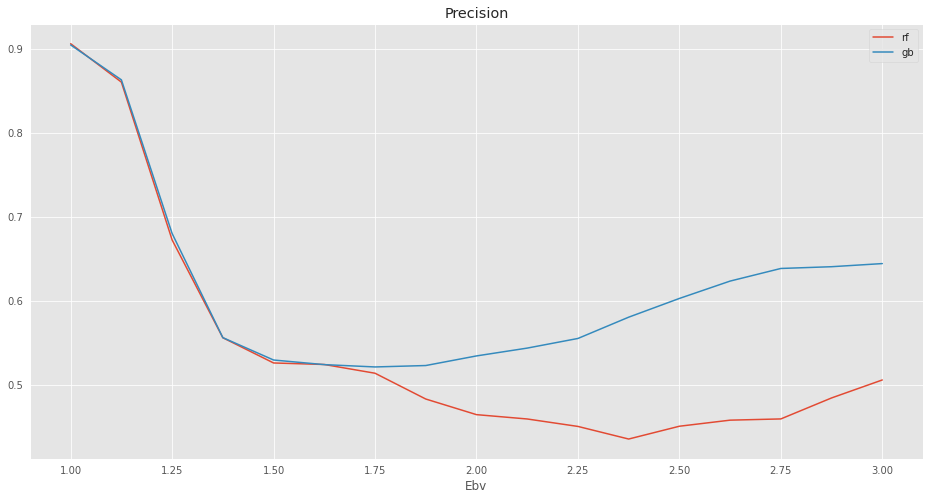

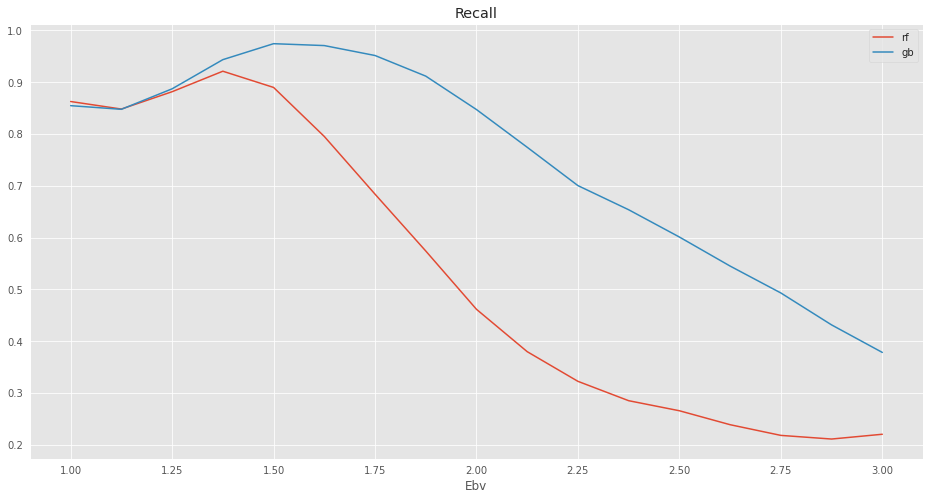

In [100]:
AU_REC(rf1, X_test_not_scaling, X_train_not_scaling1, y_test, "Random forest, precision recall curve", x0=1, x1=3.2)
AU_REC(gb1, X_test_not_scaling, X_train_not_scaling1, y_test, "Gradient boosting, precision recall curve", x0=1, x1=3.2)
AUC_ROC(rf1, X_test_not_scaling, X_train_not_scaling1, y_test, "Random forest, ROC", x0=1, x1=3.2)
AUC_ROC(gb1, X_test_not_scaling, X_train_not_scaling1, y_test, "Gradient boosting, ROC", x0=1, x1=3.2)
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf1, X_test_not_scaling, X_train_not_scaling1, y_test, x0=1, x1=3.125)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb1, X_test_not_scaling, X_train_not_scaling1, y_test, x0=1, x1=3.125)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

Влияние ошибок не обнаружено за счет нормировки данных перед подачей в классификатор 

# Звезды против Галактик и Квазаров 


In [42]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation(X_main, y_main, c, 0.7)

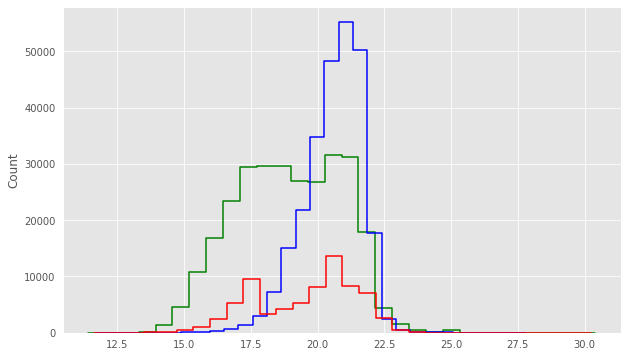

In [43]:
fig, ax1 = plt.subplots(ncols = 1, figsize = (10, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step", fill=False)
sns.histplot(X3_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'b', element="step", fill=False)
sns.histplot(X2_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'r', element="step", fill=False)

In [44]:
from lightgbm import LGBMClassifier
#gb = joblib.load('gb.pkl')
gb = LGBMClassifier(n_estimators=1100,
                    num_leaves=31,
                    learning_rate=0.01,
                    max_depth=14,
                    min_child_weight=3,
                    subsample=0.8167537919943857,
                    colsample_bytree=0.5)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90    672255
           1       0.88      0.94      0.91    672254

    accuracy                           0.90   1344509
   macro avg       0.90      0.90      0.90   1344509
weighted avg       0.90      0.90      0.90   1344509

Confusion Matrix: 
 [[584346  87909]
 [ 42528 629726]]
Training Score:  0.8950081170141007
Testing Score:  0.9029854021058988


In [ ]:
rf = RandomForestClassifier(n_estimators=300,
                            random_state=42,
                            max_features=5,
                            min_samples_leaf=6) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)

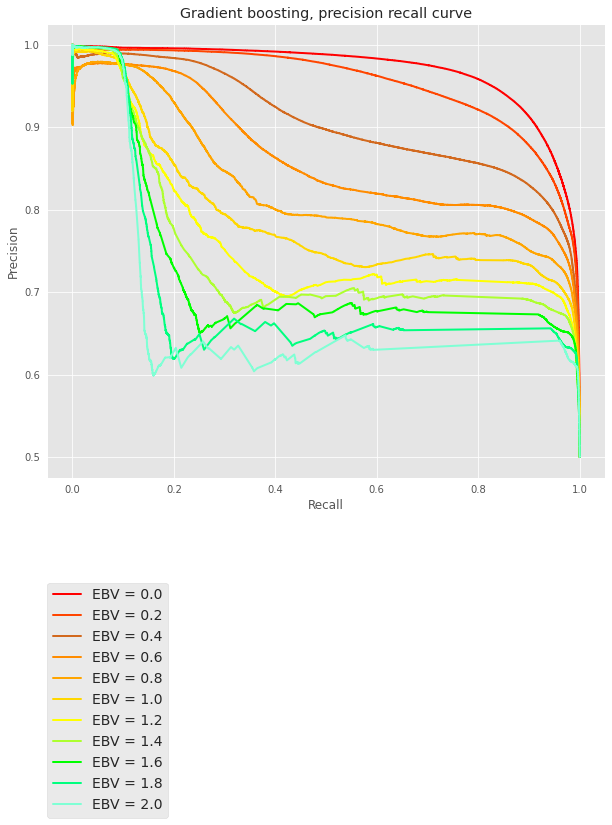

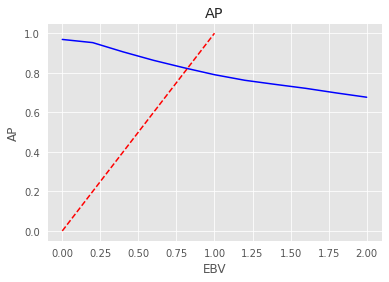

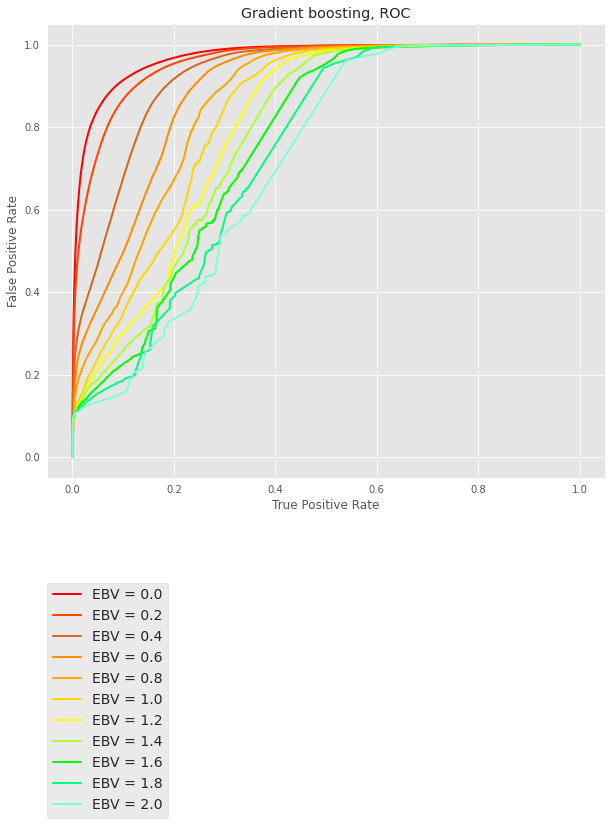

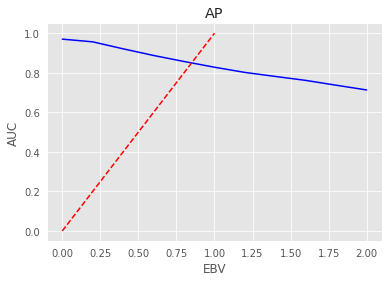

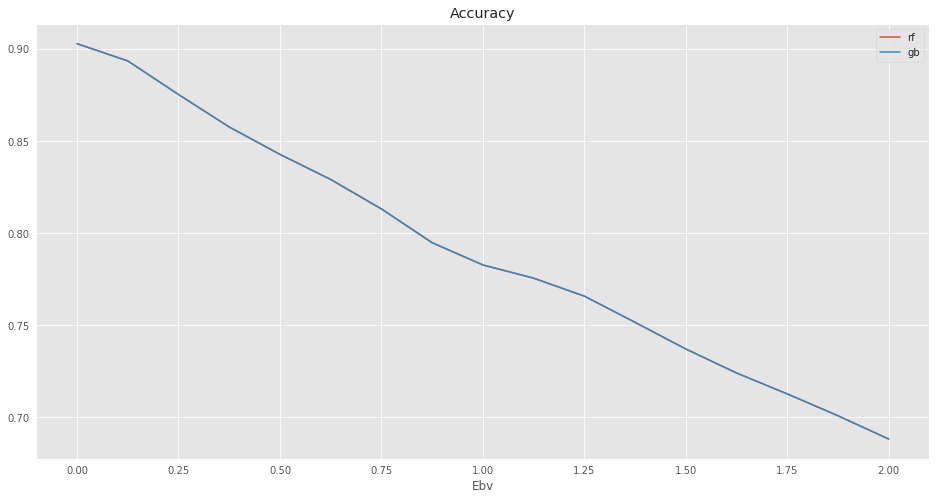

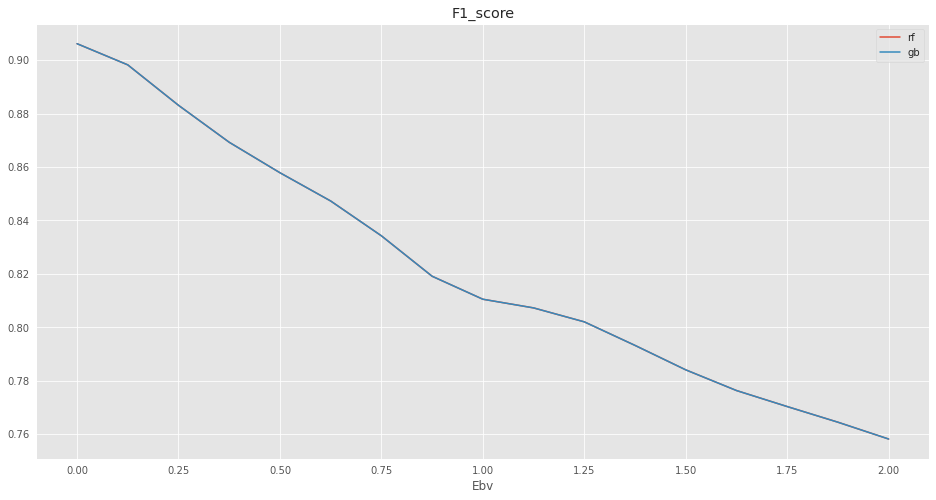

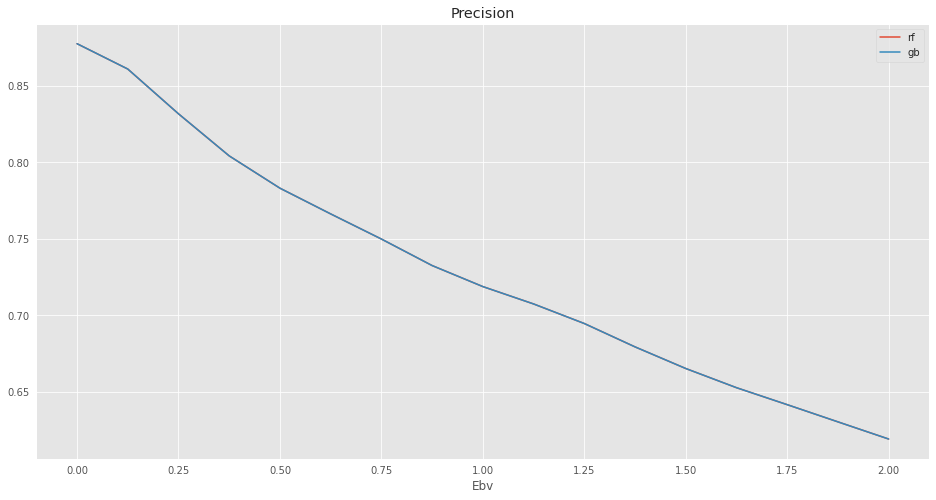

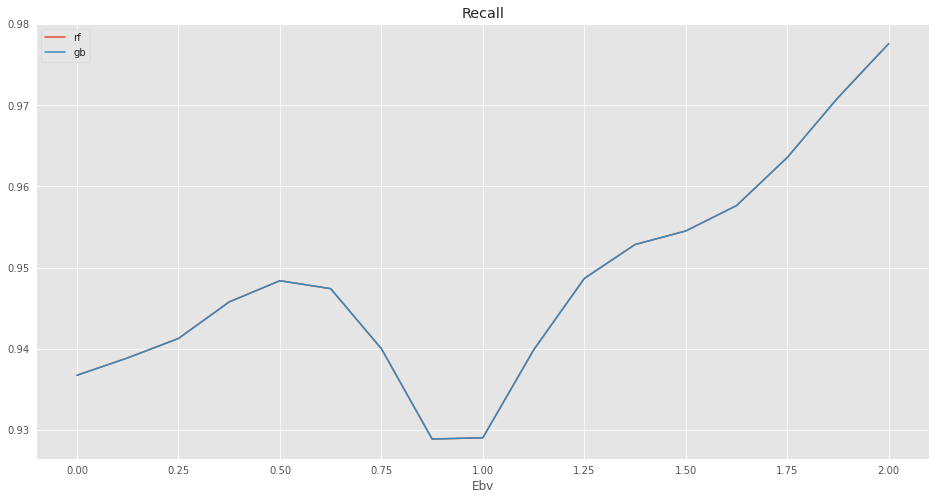

In [46]:
#Искажаем все данные 
#AU_REC(rf, X_test_not_scaling, X_train_not_scaling, y_test, "Random forest, precision recall curve")
AU_REC(gb, X_test_not_scaling, X_train_not_scaling, y_test, "Gradient boosting, precision recall curve")
#AUC_ROC(rf, X_test_not_scaling, X_train_not_scaling, y_test, "Random forest, ROC")
AUC_ROC(gb, X_test_not_scaling, X_train_not_scaling, y_test, "Gradient boosting, ROC")
#test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test)
visualize(test_acc_gb, test_acc_gb, test_f1_gb, test_f1_gb, test_precision_gb, test_precision_gb, test_recall_gb, test_recall_gb, grid, "Ebv")